# Final Project

https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import networkx as nx
from itertools import combinations
from networkx.algorithms import bipartite

In [3]:
recipes_df = pd.read_csv('RAW_recipes.csv')

In [4]:
recipes_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


In [5]:
## ingredeints are a string not a list
## use ast package to change

recipes_df['ingredients'] = recipes_df['ingredients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else [])

In [6]:
users_df = pd.read_csv('RAW_interactions.csv')
users_df

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


## Ignore Duplicates

In [7]:
recipes_df = recipes_df.drop_duplicates(subset=['id'])
users_df = users_df.drop_duplicates(subset=['user_id', 'recipe_id'])

In [8]:
users_df['user_id'].nunique()

226570

In [9]:
## Develop Network of Ingredients
recipes_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"[celery, onion, green sweet pepper, garlic clo...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"[paprika, salt, garlic powder, onion powder, d...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","[hard-cooked eggs, mayonnaise, dijon mustard, ...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","[butter, eagle brand condensed milk, light bro...",10


In [10]:
recipes_exploded = recipes_df[['name', 'id', 'ingredients']].explode('ingredients')
recipes_exploded

,name,id,ingredients
0,arriba baked winter squash mexican style,137739,winter squash
0,arriba baked winter squash mexican style,137739,mexican seasoning
0,arriba baked winter squash mexican style,137739,mixed spice
0,arriba baked winter squash mexican style,137739,honey
0,arriba baked winter squash mexican style,137739,butter
...,...,...,...
231636,cookies by design sugar shortbread cookies,298509,eggs
231636,cookies by design sugar shortbread cookies,298509,flour
231636,cookies by design sugar shortbread cookies,298509,cream of tartar
231636,cookies by design sugar shortbread cookies,298509,baking soda


In [11]:
recipes_network = pd.merge(recipes_exploded, users_df, left_on='id', right_on='recipe_id', how='left')
recipes_network

,name,id,ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,winter squash,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,winter squash,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,winter squash,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,arriba baked winter squash mexican style,137739,mexican seasoning,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
4,arriba baked winter squash mexican style,137739,mexican seasoning,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
...,...,...,...,...,...,...,...,...
10136976,cookies by design sugar shortbread cookies,298509,baking soda,1546277,298509,2010-02-08,5,"yummy cookies, i love this recipe me and my sm..."
10136977,cookies by design sugar shortbread cookies,298509,baking soda,1803287907,298509,2014-11-01,0,I work at a Cookies By Design and can say this...
10136978,cookies by design sugar shortbread cookies,298509,vanilla extract,866651,298509,2008-06-19,1,This recipe tastes nothing like the Cookies by...
10136979,cookies by design sugar shortbread cookies,298509,vanilla extract,1546277,298509,2010-02-08,5,"yummy cookies, i love this recipe me and my sm..."


In [12]:
recipes_network[['ingredients', 'recipe_id']]

,ingredients,recipe_id
0,winter squash,137739
1,winter squash,137739
2,winter squash,137739
3,mexican seasoning,137739
4,mexican seasoning,137739
...,...,...
10136976,baking soda,298509
10136977,baking soda,298509
10136978,vanilla extract,298509
10136979,vanilla extract,298509


## Exploratory Data Analysis

In [13]:
recipes_network['ingredients'].nunique()

14942

### Number of Times Ingredient Was Used

In [14]:
recipes_network.groupby(['ingredients'])['recipe_id'].nunique().reset_index().sort_values(by='recipe_id', ascending=False).rename(columns={'recipe_id':'total_recipes'}).head(10)

,ingredients,total_recipes
11751,salt,85746
1651,butter,54975
12908,sugar,44535
9414,onion,39065
14316,water,34914
4453,eggs,33761
9397,olive oil,32822
4941,flour,26266
8727,milk,25786
5692,garlic cloves,25748


## Network Centrality Measures

In [15]:
# Group by recipe_id to get lists of ingredients per recipe
temp_df = recipes_network[['ingredients', 'recipe_id']].sample(100000)
grouped = temp_df.groupby('recipe_id')['ingredients'].apply(set).reset_index()


In [16]:
# Create an undirected graph
G = nx.Graph()

# Add edges for each pair of ingredients in the same recipe
for ingredients in grouped['ingredients']:
    for ingredient1, ingredient2 in combinations(ingredients, 2):
        if G.has_edge(ingredient1, ingredient2):
            G[ingredient1][ingredient2]['weight'] += 1
        else:
            G.add_edge(ingredient1, ingredient2, weight=1)

### Degree Centrality

In [17]:
# Compute degree centrality (normalized between 0 and 1)
degree_centrality = nx.degree_centrality(G)

degree_df = pd.DataFrame(degree_centrality.items(), columns=['ingredient', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
degree_df.head(10)

,ingredient,degree_centrality
14,salt,0.324929
43,butter,0.220113
90,onion,0.207365
1,water,0.198017
45,sugar,0.185269
41,olive oil,0.165439
0,garlic,0.149008
57,eggs,0.147875
35,garlic cloves,0.146459
70,flour,0.140227


### Eigenvector Centrality

In [18]:
# Compute Eigenvector centrality (normalized between 0 and 1)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)

eigen_df = pd.DataFrame(eigenvector_centrality.items(), columns=['ingredient', 'eigenvector_centrality'])
eigen_df = eigen_df.sort_values(by='eigenvector_centrality', ascending=False)

eigen_df.head(10)

,ingredient,eigenvector_centrality
14,salt,0.172693
43,butter,0.142207
90,onion,0.142204
1,water,0.136059
45,sugar,0.129061
41,olive oil,0.126306
35,garlic cloves,0.119651
0,garlic,0.118107
70,flour,0.115704
33,pepper,0.109776


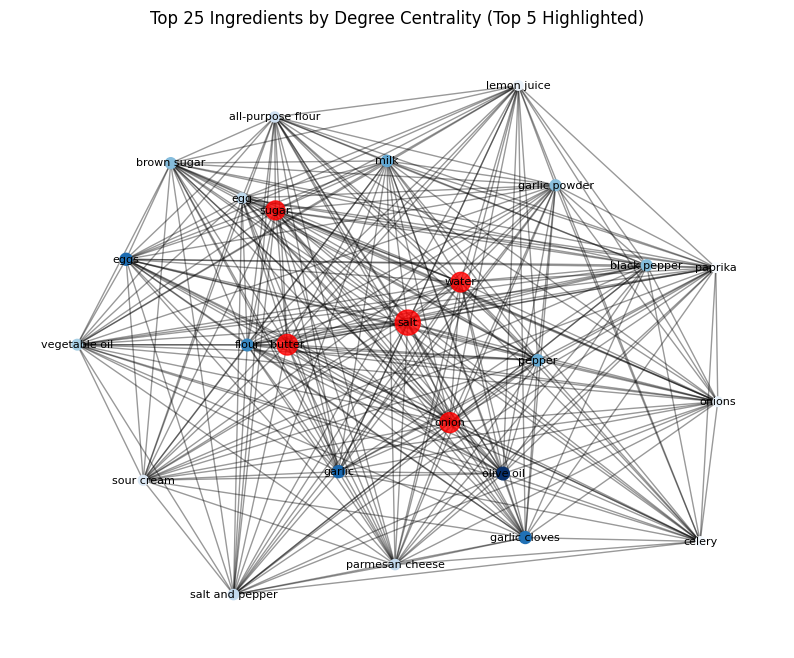

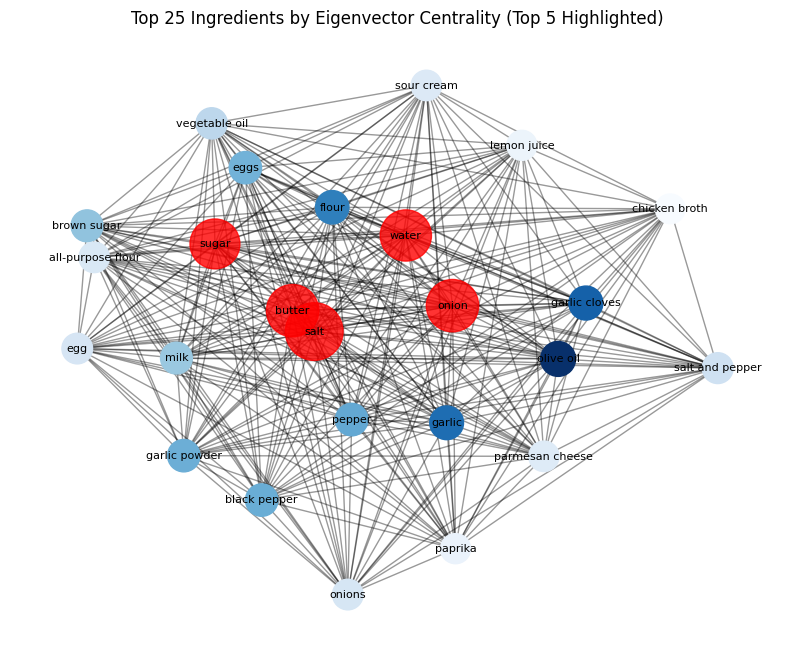

In [19]:
G_subgraph = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Use raw centrality values directly
degree_centrality_values = degree_centrality
eigenvector_centrality_values = eigenvector_centrality

# Get top 25 nodes by degree centrality
nodes_top25_degree = sorted(degree_centrality_values, key=degree_centrality_values.get, reverse=True)[:25]
nodes_top5_degree = nodes_top25_degree[:5]

# Get top 25 nodes by eigenvector centrality
nodes_top25_eigen = sorted(eigenvector_centrality_values, key=eigenvector_centrality_values.get, reverse=True)[:25]
nodes_top5_eigen = nodes_top25_eigen[:5]

# Create subgraphs for top 25 ingredients
G_degree_25 = G_subgraph.subgraph(nodes_top25_degree).copy()
G_eigen_25 = G_subgraph.subgraph(nodes_top25_eigen).copy()

# Layouts
pos_degree_25 = nx.spring_layout(G_degree_25, seed=123, k=0.1)
pos_eigen_25 = nx.spring_layout(G_eigen_25, seed=123, k=0.1)

# Plot Degree Centrality
plt.figure(figsize=(10, 8))
non_top5_nodes_degree = [n for n in G_degree_25.nodes() if n not in nodes_top5_degree]
nx.draw_networkx_nodes(G_degree_25, pos_degree_25,
                       nodelist=non_top5_nodes_degree,
                       node_size=[degree_centrality_values[n]*500 for n in non_top5_nodes_degree],
                       node_color=[degree_centrality_values[n] for n in non_top5_nodes_degree],
                       cmap=plt.cm.Blues)
nx.draw_networkx_nodes(G_degree_25, pos_degree_25,
                       nodelist=nodes_top5_degree,
                       node_size=[degree_centrality_values[n]*1000 for n in nodes_top5_degree],
                       node_color='red', alpha=0.8)
nx.draw_networkx_edges(G_degree_25, pos_degree_25, alpha=0.4)
nx.draw_networkx_labels(G_degree_25, pos_degree_25, font_size=8)
plt.title("Top 25 Ingredients by Degree Centrality (Top 5 Highlighted)")
plt.axis('off')
plt.show()

# Plot Eigenvector Centrality
plt.figure(figsize=(10, 8))
non_top5_nodes_eigen = [n for n in G_eigen_25.nodes() if n not in nodes_top5_eigen]
nx.draw_networkx_nodes(G_eigen_25, pos_eigen_25,
                       nodelist=non_top5_nodes_eigen,
                       node_size=[eigenvector_centrality_values[n]*5000 for n in non_top5_nodes_eigen],
                       node_color=[eigenvector_centrality_values[n] for n in non_top5_nodes_eigen],
                       cmap=plt.cm.Blues)
nx.draw_networkx_nodes(G_eigen_25, pos_eigen_25,
                       nodelist=nodes_top5_eigen,
                       node_size=[eigenvector_centrality_values[n]*10000 for n in nodes_top5_eigen],
                       node_color='red', alpha=0.8)
nx.draw_networkx_edges(G_eigen_25, pos_eigen_25, alpha=0.4)
nx.draw_networkx_labels(G_eigen_25, pos_eigen_25, font_size=8)
plt.title("Top 25 Ingredients by Eigenvector Centrality (Top 5 Highlighted)")
plt.axis('off')
plt.show()

## Unweighted and Weighted Network

In [20]:
recipes_network

,name,id,ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,winter squash,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,winter squash,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,winter squash,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,arriba baked winter squash mexican style,137739,mexican seasoning,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
4,arriba baked winter squash mexican style,137739,mexican seasoning,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
...,...,...,...,...,...,...,...,...
10136976,cookies by design sugar shortbread cookies,298509,baking soda,1546277,298509,2010-02-08,5,"yummy cookies, i love this recipe me and my sm..."
10136977,cookies by design sugar shortbread cookies,298509,baking soda,1803287907,298509,2014-11-01,0,I work at a Cookies By Design and can say this...
10136978,cookies by design sugar shortbread cookies,298509,vanilla extract,866651,298509,2008-06-19,1,This recipe tastes nothing like the Cookies by...
10136979,cookies by design sugar shortbread cookies,298509,vanilla extract,1546277,298509,2010-02-08,5,"yummy cookies, i love this recipe me and my sm..."


In [21]:
top_25_degree = degree_df.reset_index(drop=True)['ingredient'][:25]
top_25_eigen = eigen_df.reset_index(drop=True)['ingredient'][:25]

In [22]:
top_25_combined = pd.concat([top_25_degree, top_25_eigen]).unique()
len(top_25_combined)

26

In [23]:
grouped

,recipe_id,ingredients
0,39,{cilantro}
1,41,{zucchini}
2,49,{flour}
3,53,{applesauce}
4,62,{cayenne}
...,...,...
54943,536464,{baguette}
54944,536662,{vegetable oil}
54945,536747,{marshmallows}
54946,537037,{cheese wheel}


In [24]:
bipartite_data = temp_df
bipartite_data_filtered = bipartite_data[bipartite_data['ingredients'].isin(top_25_combined)]

In [25]:
bipartite_data_filtered

,ingredients,recipe_id
8530273,salt,325544
6527087,garlic,17722
9001599,salt,53075
5480067,salt,42907
3884951,butter,166036
...,...,...
8490768,onion,317123
3573258,sugar,314073
1859431,flour,20884
513445,salt,104611


In [26]:
len(bipartite_data_filtered['ingredients'].unique())

26

In [27]:
R = nx.Graph()

R.add_nodes_from(bipartite_data_filtered["ingredients"], bipartite=0)  
R.add_nodes_from(bipartite_data_filtered["recipe_id"], bipartite=1)   
R.add_edges_from(zip(bipartite_data_filtered["ingredients"], bipartite_data_filtered["recipe_id"]))  

recipe_nodes = bipartite_data_filtered["recipe_id"].unique()
projected_graph = nx.bipartite.projected_graph(R, recipe_nodes)

recipe_degree_df = pd.DataFrame(list(projected_graph.degree()), columns=['Recipe', 'Users'])
recipe_degree_df.sort_values(by='Users', ascending=False).head(10)

KeyboardInterrupt: 

In [ ]:
weighted_projected_graph = bipartite.weighted_projected_graph(R, recipe_nodes)
recipe_weight_df = pd.DataFrame(list(weighted_projected_graph.degree(weight='weight')), columns=['Recipe', 'Users'])
recipe_weight_df = recipe_weight_df.sort_values(by='Users', ascending=False)
recipe_weight_df.head(10)

In [ ]:
## Sample Sizing??

In [ ]:
recipes_users_df = pd.merge(recipes_df, users_df, left_on='id', right_on='recipe_id', how='left')
recipes_users_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ..."
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...


In [ ]:
recipe_review_counts = recipes_users_df.groupby('id')['user_id'].count().reset_index(name='total_reviews').sort_values(by='total_reviews', ascending=False)
recipe_review_counts

,id,total_reviews
833,2886,1613
14424,27208,1601
51312,89204,1579
21639,39087,1448
38631,67256,1322
...,...,...
162491,307214,1
100230,176578,1
100231,176579,1
100232,176581,1


In [ ]:
temp_df = recipe_review_counts.groupby('total_reviews').count().reset_index()
temp_df

,total_reviews,id
0,1,91953
1,2,45120
2,3,25259
3,4,15712
4,5,10709
...,...,...
357,1322,1
358,1448,1
359,1579,1
360,1601,1


In [ ]:
recipe_review_counts = recipes_users_df.groupby(['recipe_id', 'rating']).size().reset_index(name='count')

In [ ]:
recipe_user_count_df.pivot(index='recipe_id', columns='rating', values='count')

NameError: name 'recipe_user_count_df' is not defined

## Text NLP Stuff

In [29]:
import pandas as pd
from collections import Counter
import re

recipe_description = recipes_df[['id', 'description']].sample(10)

# Function to get normalized word frequency per row
# Updated function to handle NaNs or non-string entries
def normalized_word_freq(text):
    if not isinstance(text, str):
        return {}
    words = re.findall(r'\b\w+\b', text.lower())
    total = len(words)
    counts = Counter(words)
    return {word: count / total for word, count in counts.items()} if total > 0 else {}


# Step 1: Apply the normalized word frequency function
recipe_description['word_freq'] = recipe_description['description'].apply(normalized_word_freq)

# Step 2: Reset index to align properly before expansion
recipe_description_reset = recipe_description.reset_index(drop=True)

# Step 3: Expand the word_freq dictionaries into a DataFrame
word_freq_df = pd.DataFrame(recipe_description_reset['word_freq'].to_list()).fillna(0)

# Step 4: Combine word frequencies with the corresponding recipe ID
result_df = pd.concat([recipe_description_reset[['id']], word_freq_df], axis=1)


result_df


,id,from,www,topsecretrecipes,com,this,is,a,favorite,sandwich,...,fond,carrots,have,enjoyed,way,fixing,quick,tasty,goes,anything
0,304411,0.030303,0.030303,0.030303,0.030303,0.030303,0.030303,0.060606,0.030303,0.030303,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,88028,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,275300,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.100000,0.000000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,270198,0.027778,0.000000,0.000000,0.000000,0.027778,0.027778,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,37486,0.015152,0.000000,0.000000,0.015152,0.015152,0.015152,0.030303,0.000000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,105637,0.022727,0.000000,0.000000,0.000000,0.045455,0.022727,0.045455,0.000000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,225775,0.009615,0.000000,0.000000,0.000000,0.000000,0.009615,0.009615,0.000000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,397641,0.000000,0.000000,0.000000,0.000000,0.058824,0.019608,0.019608,0.000000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,380798,0.000000,0.000000,0.000000,0.000000,0.015385,0.015385,0.015385,0.000000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,58747,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,...,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04


In [ ]:
recipe_description

,id,description
0,137739,autumn is my favorite time of year to cook! th...
1,31490,this recipe calls for the crust to be prebaked...
2,112140,this modified version of 'mom's' chili was a h...
3,59389,"this is a super easy, great tasting, make ahea..."
4,44061,my dh's amish mother raised him on this recipe...
...,...,...
231632,486161,this is a delicious soup that i originally fou...
231633,493372,this spice mix will make your taste buds dance!
231634,308080,"deviled eggs, cajun-style"
231635,298512,"i've heard of the 'cookies by design' company,..."
